<a href="https://colab.research.google.com/github/vanadnarayane26/IMDB-sentiment-analysis-/blob/main/BERT_uncased_fine_tuned_for_IMDB_50k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
tf.get_logger().setLevel('ERROR')

In [10]:
!gdown https://drive.google.com/uc?id=1W3oJKBRcJ9l-IiPpaVPRo2En7X5vMZf5

Downloading...
From: https://drive.google.com/uc?id=1W3oJKBRcJ9l-IiPpaVPRo2En7X5vMZf5
To: /content/IMDB Dataset.csv.zip
27.0MB [00:00, 65.1MB/s]


In [11]:
os.rename('IMDB Dataset.csv.zip','IMDB_Dataset.csv.zip')

In [12]:
!unzip /content/IMDB_Dataset.csv.zip

Archive:  /content/IMDB_Dataset.csv.zip
replace IMDB Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: IMDB Dataset.csv        


In [13]:
df = pd.read_csv('/content/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [14]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [15]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

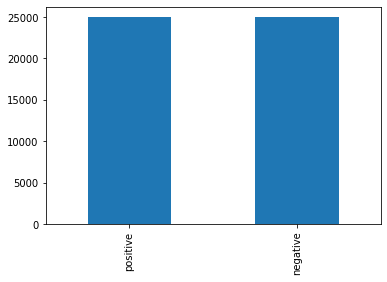

In [16]:
df['sentiment'].value_counts().plot.bar()
plt.show()

In [17]:
def encoder_funct(df):
    encode_y = LabelEncoder()
    y = encode_y.fit_transform(df['sentiment'])
    return y
y = encoder_funct(df)
df['sentiment_encoded'] = y 

In [18]:
df.head()

,review,sentiment,sentiment_encoded
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [19]:
raw_df_ds = tf.data.Dataset.from_tensor_slices((df['review'].values,df['sentiment_encoded'].values))
validation_size = int(0.2*df.shape[0])
train_size = df.shape[0]-validation_size
print(validation_size)
print(train_size)

10000
40000


In [20]:
seeD = 42
raw_df_ds = raw_df_ds.shuffle(seeD)
raw_train_ds = raw_df_ds.take(train_size)
raw_val_ds = raw_df_ds.skip(train_size)

In [21]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

raw_train_ds = raw_train_ds.batch(batch_size = batch_size)
raw_val_ds = raw_val_ds.batch(batch_size = batch_size)

In [22]:
#print train set
for review,sentiment in raw_train_ds.take(1):
    for i in range(5):
      print(review.numpy()[i])
      print('sentiment:',sentiment.numpy()[i])

b"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."
sentiment: 0
b"Kind of drawn in by the erotic scenes, only to realize this was one of the most amateurish and unbelievable bits of film I've ever seen. Sort of like a high school film project. What was Rosanna Arquette thinking?? And what was with 

In [23]:
#print validation set
for review,sentiment in raw_val_ds.take(1):
    for i in range(5):
      print(review.numpy()[i])
      print('sentiment:',sentiment.numpy()[i])

b"Actually had to stop it. Don't get me wrong, love bad monster movies. But this one was way too boring, regardless of the suspenseful music that never leads you anywhere. The actress had too many teeth and that moment when she makes contact with one of the beasts, was way too obvious a clich\xc3\xa9. This film totally betrays the cover on the DVD which looks pretty interesting. From the cover one expects a giant monster, but you get these cute not as gigantic as expected electric eels. Moved on to watch another film called The Killer Rats but that's another review. Deep Shock was really crap, a big shame considering the fact that it looks pretty high budget."
sentiment: 0
b'"Mr. Bug Goes To Town" was the last major achievement the Fleischer studios produced. The quality of the Superman series produced at the same time is evident in this extraordinary film.<br /><br />The music and lyrics by Frank Loesser and Hoagy Carmichael (with assistance by Flieshcer veteran Sammy Timberg are quit

In [24]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'

In [25]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

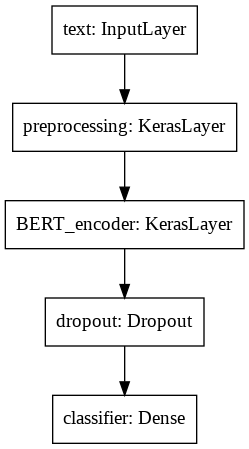

In [26]:
bert_uncased = build_classifier_model()
tf.keras.utils.plot_model(bert_uncased)

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 1,min_delta = 0.005)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(raw_train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
bert_uncased.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
print(f'Training model with {tfhub_handle_encoder}')
history = bert_uncased.fit(x=raw_train_ds,
                               validation_data=raw_val_ds,
                               epochs=epochs,
                               callbacks = [callback])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/3
1250/1250 [==============================] - 1271s 1s/step - loss: 0.3521 - binary_accuracy: 0.8274 - val_loss: 0.2630 - val_binary_accuracy: 0.8827
Epoch 2/3
1250/1250 [==============================] - 1261s 1s/step - loss: 0.1820 - binary_accuracy: 0.9275 - val_loss: 0.3329 - val_binary_accuracy: 0.8955


In [28]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

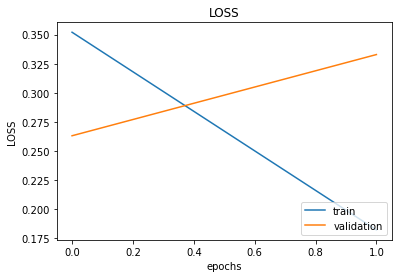

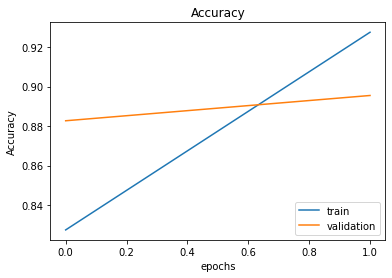

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'],loc = 'lower right')
plt.xlabel('epochs')
plt.ylabel('LOSS')
plt.title('LOSS')
plt.show()

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.legend(['train','validation'],loc = 'lower right')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()